# Задача Сегментации ядер клеток с помощью моделей на основе архетикутр U-Net и DeepLabv3+

### Импорт библиотек

In [1]:
import os
import cv2
import PIL
from tqdm import tqdm
from PIL import Image
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp

/home/alkon/anaconda3/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Подготовка и анализ данных

In [3]:
# Зафиксируем сиды, чтобы воспроизводимости добавить
seed = 24
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.mps.manual_seed(seed)

In [4]:
# Разархивируем данные
# !unzip -q './data/test.zip' -d './data/test'
# !unzip -q './data/train.zip' -d './data/train'

In [5]:
root =  './data/'

In [6]:
train_ann_path = os.path.join(root,"train_labels.csv")
sample_ann_path = os.path.join(root,"sample_submission.csv")

In [7]:
# Читаем аннотацию
train_df = pd.read_csv(train_ann_path)
sample_df = pd.read_csv(sample_ann_path)

In [8]:
train_df

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
...,...,...
29456,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...
29457,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,110318 4 110675 13 111034 19 111391 23 111750 ...
29458,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...
29459,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...


In [9]:
sample_df

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,1 1
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,1 1
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,1 1
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,1 1
...,...,...
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 1
61,f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...,1 1
62,f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60a...,1 1
63,fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...,1 1


In [10]:
### Создаем наш датасет
class NucleusSegmentationDataset (data.Dataset):
    def __init__(self,img_dir,image_ids,transform=None,mask_transform=None):
        
        """
        Params:
            root_dir (string): Путь к папке с изображениями и масками.
            image_ids (list): Список ID изображений для этого датасета (train или test).
            transform (callable, optional): Трансформации для изображений.
            mask_transform (callable, optional): Трансформации для масок.
        """
        self.root_dir = img_dir
        self.transform = transform
        self.mask_transform = mask_transform # Используем переданный список
        self.image_ids = image_ids # Используем переданный список


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self,idx):
        img_id = self.image_ids[idx]
        img_id_path = os.path.join(self.root_dir,img_id)

        img_path = os.path.join(img_id_path, "images",f"{img_id}.png")
        
        if not os.path.exists(img_path): # если нет такой, ругаемся
            print('No file ', img_path)
            pass
            
        # Сразу используем PIL тк torchvision.transforms работает с PIL Image
        image = Image.open(img_path).convert('L')
        # Применяем к изображению выбранное преобразование (аугментацию) (!!! Нельзя поворачивать и все такое. Потому что маска не повернется. Нужно использовать другие библиотеки для такой задачи)
        combined_mask = np.zeros((image.height, image.width), dtype=np.float32)
        image = self.transform(image)

        mask_folder_path = os.path.join(img_id_path,"masks")
        

        for mask_file in os.listdir(mask_folder_path):
            mask_path = os.path.join(mask_folder_path, mask_file)
            individual_mask = np.array(Image.open(mask_path).convert("L"))
            combined_mask = np.maximum(combined_mask, individual_mask / 255.0)
            
        if self.mask_transform:
            # Превращаем numpy маску в PIL Image для трансформации
            combined_mask_pil = Image.fromarray(combined_mask)
            mask = self.mask_transform(combined_mask_pil)
            # mask = torch.squeeze(mask).float()
            mask = mask.float()
        else:
            mask = torch.from_numpy(combined_mask).float()
            mask = mask.unsqueeze(0)
            
        return image, mask
                


In [11]:
TRAIN_DIR = "data/train"

In [12]:
all_image_ids = os.listdir(TRAIN_DIR)

In [13]:
len(all_image_ids)

670

*Делим на тренировочную и тестовую выборку*

In [14]:
train_ids, test_ids = train_test_split(all_image_ids,test_size=0.2,random_state=42)

In [15]:
len(train_ids),len(test_ids)

(536, 134)

*Подготавливаем наш датасет и даталоадер для обучения*

In [15]:
train_img_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    # T.RandomHorizontalFlip(), # Пример нельзя аугментировать таким образом, т.к это не будет применяться к маске
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [16]:
val_img_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    # T.RandomHorizontalFlip(), # Пример нельзя аугментировать таким образом, т.к это не будет применяться к маске
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [17]:
mask_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [18]:
trainset = NucleusSegmentationDataset(TRAIN_DIR,train_ids,train_img_transforms,mask_transforms)
testset = NucleusSegmentationDataset(TRAIN_DIR,test_ids,val_img_transforms,mask_transforms)

In [19]:
# batch_size можно увеличивать в зависимости от возможности доступной GPU
train_dataloader = torch.utils.data.DataLoader(trainset,
                                               batch_size=16,
                                               shuffle=True,
                                               num_workers=4)
test_dataloader = torch.utils.data.DataLoader(testset,
                                               batch_size=16,
                                               shuffle=False,
                                               num_workers=4)

 <h1>Классическая U-Net которую мы будем реализовывать</h1>
    <img src=https://habrastorage.org/r/w1560/webt/un/ay/gn/unaygnyzsdhk_2dbk4qq2-2m340.png alt="Пример изображения на сайте">

In [20]:
## Создадим класс двойной свертки
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)

        )
    def forward(self, x):
        return self.double_conv(x)

In [21]:
## Создает класс нашей сети классической U-net
class MyUNet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(MyUNet,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels 

        ##Encoder(сжимание)
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.25)
        self.drop3 = nn.Dropout(0.25)
        self.drop4 = nn.Dropout(0.25)

        self.bottleneck = DoubleConv(512, 1024)

        ## Decoder (Расширение)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64,out_channels,kernel_size=1)

    def forward(self,x):
        ##Encoder
        x1 = self.down1(x)
        x2 = self.down2(self.pool(x1))
        x3 = self.down3(self.pool(x2))
        x4 = self.down4(self.pool(x3))
        ## Bottleneck
        b = self.bottleneck(self.pool(x4))
        ## Decoder 
        u4 = self.upconv4(b)
        ## skip connection
        cat4 = torch.cat([u4,x4],dim=1) ## создает связь напрямую от x4 к u4
        d4 = self.up4(cat4)

        u3 = self.upconv3(d4)
        ## skip connection
        cat3 = torch.cat([u3,x3],dim=1) ## создает связь напрямую от x3 к u3
        d3 = self.up3(cat3)

        u2 = self.upconv2(d3)
        ## skip connection
        cat2 = torch.cat([u2,x2],dim=1) ## создает связь напрямую от x2 к u2
        d2 = self.up2(cat2)

        u1 = self.upconv1(d2)
        ## skip connection
        cat1 = torch.cat([u1,x1],dim=1) ## создает связь напрямую от x1 к u1
        d1 = self.up1(cat1)

        return self.out_conv(d1)

In [16]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 15 # Для примера, в реальности нужно больше
NUM_WORKERS = 4
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [17]:
device = DEVICE

In [24]:
model = MyUNet(in_channels=1,out_channels=1).to(device)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(),lr=1e-4)

In [44]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    """Функция для обучения модели на одной эпохе."""
    loop = tqdm(loader, leave=True)
    model.train() # Переводим модель в режим обучения
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward pass (прямое распространение)
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        
        # Backward pass (обратное распространение)
        optimizer.zero_grad() # Обнуляем градиенты
        loss.backward()       # Считаем градиенты
        optimizer.step()      # Обновляем веса
        
        # Обновляем информацию в progress bar
        loop.set_postfix(loss=loss.item())

In [46]:
def check_accuracy(loader, model, device="cuda"):
    """Функция для проверки точности модели на валидационной выборке."""
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    model.eval() # Переводим модель в режим оценки

    with torch.no_grad(): # Отключаем расчет градиентов
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            preds = torch.sigmoid(model(x)) # Применяем сигмоиду, чтобы получить вероятности
            preds = (preds > 0.5).float()   # Применяем порог 0.5, чтобы получить бинарную маску
            
            # Считаем попиксельную точность
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            
            # Считаем Dice Score (более релевантная метрика для сегментации)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    accuracy = num_correct / num_pixels * 100
    avg_dice_score = dice_score / len(loader)
    
    print(
        f"Validation Accuracy: {accuracy:.2f}%"
    )
    print(f"Validation Dice Score: {avg_dice_score:.4f}")
    
    model.train() # Возвращаем модель в режим обучения
    return avg_dice_score

In [28]:
best_val_dice = -1.0
scheduler = StepLR(optim, step_size=5, gamma=0.5) # Планировщик для LR

In [29]:
NUM_EPOCHS = 20 # 
for epoch in range(NUM_EPOCHS):
    print(f"--- Эпоха {epoch+1}/{NUM_EPOCHS} ---")
    
    # Запускаем обучение на одной эпохе
    train_one_epoch(train_dataloader, model, optim, loss_fn, DEVICE)
    
    # Проверяем качество на валидационной выборке
    current_dice = check_accuracy(test_dataloader, model, DEVICE)
    scheduler.step()
    # Сохраняем модель, если она показала лучший результат
    if current_dice > best_val_dice:
        best_val_dice = current_dice
        torch.save(model.state_dict(), "best_unet_model.pth")
        print("=> Модель сохранена как лучшая")

print("--- Обучение завершено ---")


--- Эпоха 1/20 ---


100%|███████████████████████████████| 34/34 [00:13<00:00,  2.47it/s, loss=0.496]


Validation Accuracy: 75.53%
Validation Dice Score: 0.5935
=> Модель сохранена как лучшая
--- Эпоха 2/20 ---


100%|█████████████████████████████████| 34/34 [00:13<00:00,  2.51it/s, loss=0.4]


Validation Accuracy: 87.06%
Validation Dice Score: 0.8248
=> Модель сохранена как лучшая
--- Эпоха 3/20 ---


100%|███████████████████████████████| 34/34 [00:13<00:00,  2.44it/s, loss=0.479]


Validation Accuracy: 87.06%
Validation Dice Score: 0.8206
--- Эпоха 4/20 ---


100%|████████████████████████████████| 34/34 [00:13<00:00,  2.51it/s, loss=0.42]


Validation Accuracy: 87.61%
Validation Dice Score: 0.8603
=> Модель сохранена как лучшая
--- Эпоха 5/20 ---


100%|███████████████████████████████| 34/34 [00:16<00:00,  2.12it/s, loss=0.347]


Validation Accuracy: 87.53%
Validation Dice Score: 0.8501
--- Эпоха 6/20 ---


100%|███████████████████████████████| 34/34 [00:16<00:00,  2.10it/s, loss=0.328]


Validation Accuracy: 87.71%
Validation Dice Score: 0.8674
=> Модель сохранена как лучшая
--- Эпоха 7/20 ---


100%|████████████████████████████████| 34/34 [00:16<00:00,  2.08it/s, loss=0.28]


Validation Accuracy: 87.78%
Validation Dice Score: 0.8664
--- Эпоха 8/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.40it/s, loss=0.308]


Validation Accuracy: 87.75%
Validation Dice Score: 0.8699
=> Модель сохранена как лучшая
--- Эпоха 9/20 ---


100%|███████████████████████████████| 34/34 [00:15<00:00,  2.22it/s, loss=0.286]


Validation Accuracy: 87.78%
Validation Dice Score: 0.8735
=> Модель сохранена как лучшая
--- Эпоха 10/20 ---


100%|███████████████████████████████| 34/34 [00:15<00:00,  2.27it/s, loss=0.274]


Validation Accuracy: 87.84%
Validation Dice Score: 0.8755
=> Модель сохранена как лучшая
--- Эпоха 11/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.37it/s, loss=0.285]


Validation Accuracy: 87.86%
Validation Dice Score: 0.8760
=> Модель сохранена как лучшая
--- Эпоха 12/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.27it/s, loss=0.263]


Validation Accuracy: 87.87%
Validation Dice Score: 0.8785
=> Модель сохранена как лучшая
--- Эпоха 13/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.36it/s, loss=0.285]


Validation Accuracy: 87.89%
Validation Dice Score: 0.8783
--- Эпоха 14/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.40it/s, loss=0.288]


Validation Accuracy: 87.84%
Validation Dice Score: 0.8766
--- Эпоха 15/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.30it/s, loss=0.286]


Validation Accuracy: 87.86%
Validation Dice Score: 0.8774
--- Эпоха 16/20 ---


100%|███████████████████████████████| 34/34 [00:15<00:00,  2.22it/s, loss=0.268]


Validation Accuracy: 87.85%
Validation Dice Score: 0.8746
--- Эпоха 17/20 ---


100%|████████████████████████████████| 34/34 [00:15<00:00,  2.17it/s, loss=0.24]


Validation Accuracy: 87.91%
Validation Dice Score: 0.8803
=> Модель сохранена как лучшая
--- Эпоха 18/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.34it/s, loss=0.273]


Validation Accuracy: 87.90%
Validation Dice Score: 0.8781
--- Эпоха 19/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.34it/s, loss=0.257]


Validation Accuracy: 87.91%
Validation Dice Score: 0.8792
--- Эпоха 20/20 ---


100%|███████████████████████████████| 34/34 [00:14<00:00,  2.36it/s, loss=0.267]


Validation Accuracy: 87.93%
Validation Dice Score: 0.8805
=> Модель сохранена как лучшая
--- Обучение завершено ---


### Вывод

**`Точность модели составила почти 88% как по метрике accuracy , так и по метрике Dice Score, которая является более предпочтительнее в задачах сигментации, что в принципе является неплохим результатом.<br> Наверное можно улучшить метрику добавив аугментацию с помощью albumentations, чтобы она применялась одновременно и к маске, и к изображению, но у меня нет цели добиваться максимальной метрики , а цель просто разобраться в архитектуре U-Net`**

### Загрузка лучшей модели и визуальный анализ результатов

In [30]:
best_model = MyUNet(in_channels=1,out_channels=1).to(device)

In [31]:
best_model.load_state_dict(torch.load("best_unet_model.pth",map_location=torch.device(device)))

<All keys matched successfully>

In [32]:
best_model.eval()

MyUNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down3): DoubleCon

In [18]:
def predict_and_show_mask(model, image_path, transform, device="cuda",mode="L"):
    """
    Загружает изображение, делает предсказание маски и отображает результат.
    
    Args:
        model (torch.nn.Module): Обученная модель.
        image_path (str): Путь к файлу изображения.
        transform (albumentations.Compose): Пайплайн трансформаций.
        device (str): Устройство ('cuda' или 'cpu').
    """
    # 1. Загрузка и предобработка изображения
    image_pil = Image.open(image_path).convert(mode)
    original_width, original_height = image_pil.size
    
    # Применяем трансформации
    input_tensor = transform(image_pil) 
    
    # Добавляем батчевое измерение и отправляем на устройство
    input_batch = input_tensor.unsqueeze(0).to(device)

    # 2. Предсказание
    model.to(device)
    model.eval() # Переводим модель в режим оценки
    with torch.no_grad():
        prediction = model(input_batch)

    # 3. Постобработка результата
    # Применяем сигмоиду, чтобы получить вероятности
    
    probs = torch.sigmoid(prediction)
    
    resized_probs = F.interpolate(
        probs, 
        size=(original_height, original_width), # Целевой размер
        mode='bilinear', 
        align_corners=False
    )
    # Применяем порог 0.5, чтобы получить бинарную маску
    mask = (resized_probs > 0.5).float()
    
    # Переводим маску на CPU, в NumPy и убираем лишние измерения
    mask_np = mask.squeeze().cpu().numpy()
    
    combined_mask = np.zeros((image_pil.height, image_pil.width), dtype=np.float32)
    # Для отображения оригинального изображения, конвертируем PIL в NumPy
    image_np = np.array(image_pil)
    # 4. Визуализация
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    mask_folder_path =  os.path.join(os.path.dirname(os.path.dirname(image_path)),"masks") 
    for mask_file in os.listdir(mask_folder_path):
        mask_path = os.path.join(mask_folder_path, mask_file)
        individual_mask = np.array(Image.open(mask_path).convert("L"))
        combined_mask = np.maximum(combined_mask, individual_mask / 255.0)

    
    ax[0].imshow(image_np,cmap='gray')
    ax[0].set_title("Оригинальное изображение")
    ax[0].axis('off')
    
    ax[1].imshow(mask_np, cmap='gray')
    ax[1].set_title("Предсказанная маска")
    ax[1].axis('off')
    
    ax[2].imshow(combined_mask, cmap='gray')
    ax[2].set_title("Оригинальная маска")
    ax[2].axis('off')
    
    plt.show()

In [62]:
root

'./data/'

**Посмотрим визуально как создает маску наша обученая модель**

In [63]:
num_test_img = np.random.randint(0,len(train_df))
num_test_img            

12411

In [64]:
path_predict =os.path.join(TRAIN_DIR,train_df.ImageId.iloc[num_test_img],"images",f"{train_df.ImageId.iloc[num_test_img]}.png") 
path_predict

'data/train/62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461/images/62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461.png'

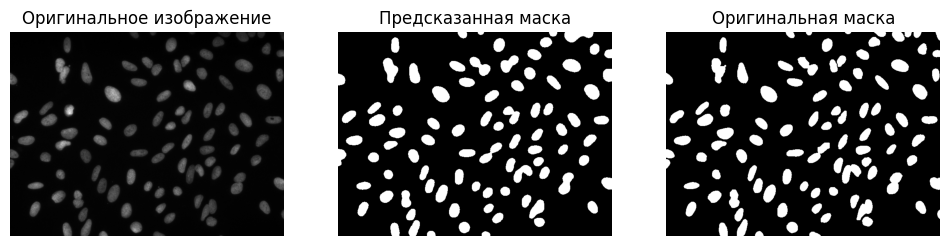

In [65]:
predict_and_show_mask(best_model, path_predict, val_img_transforms, device="cuda")

**Понятно, что нельзя оценивать работу модели визуально. Но на глаз результат выглядит очень достойно**

## Применим архетиктуру DeepLabv3 для решения данной задачи 

# DeepLabV3+

`Попробуем реализовать структуру DeepLab с нуля`

<h1>Архетиктура DeepLabv3+ которую мы будем реализовывать</h1>
    <img src=https://www.researchgate.net/publication/369605891/figure/fig3/AS:11431281131393680@1680103125602/DeepLabV3-architecture-44.ppm alt="Пример изображения на сайте">

### Реализация ASPP

In [19]:
## Вспомогательный класс для одной ветки 
class ASPPConv(nn.Module):
    def __init__(self,input_size,output_size,dilation,kernel_size):
        super(ASPPConv, self).__init__()
        self.module = nn.Sequential(
        nn.Conv2d(input_size,output_size,kernel_size,padding=dilation,dilation=dilation),
        nn.BatchNorm2d(output_size),
        nn.ReLU()
        
        )
    def forward(self,x):
        # Запоминаем исходный размер
        size = x.shape[-2:]
        # Получаем глобальный контекст
        x = self.module(x)
        # "Размазываем" контекст обратно
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

In [20]:
## Вспомогательный класс для одной ветки 
class ASPPPool(nn.Module):
    def __init__(self,input_size,output_size):
        super(ASPPPool, self).__init__()
        self.module = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), # Сжимает каждую карту признаков до размера 1x1
        nn.Conv2d(input_size, output_size, 1, bias=False),
        nn.BatchNorm2d(output_size),
        nn.ReLU()
        
        )
    def forward(self, x):
        # 1. Запоминаем исходный размер (например, 32x32)
        size = x.shape[-2:]
        
        # 2. Сжимаем до 1x1 и обрабатываем
        x = self.module(x)
        
        # 3. КРИТИЧЕСКИ ВАЖНО: Увеличиваем обратно до исходного размера
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

In [21]:
class ASPP(nn.Module):
    def __init__(self,input_size,output_size):
        super(ASPP,self).__init__()
        dilations = [1,6,12,18]
        # у меня не помещается 18, т.к картинки максимум 256х256, а классическая модель DeepLabv3+ видимо создана для больших картинок 
        # поэтому я уменьшил размер до 15
        # dilations = [1,5,7,9]
        #Свертка с dilation rate = 1 (стандартная свертка) с окном 1х1
        self.conv1x1 = ASPPConv(input_size,output_size,kernel_size=1,dilation=1)
        

        #Свертка с dilation rate = 6
        self.conv6 = ASPPConv(input_size,output_size,kernel_size=3,dilation=dilations[1])
        
        #Свертка с dilation rate = 12
        self.conv12 = ASPPConv(input_size,output_size,kernel_size=3,dilation=dilations[2])
        
        #Свертка с dilation rate = 18
        self.conv18 = ASPPConv(input_size,output_size,kernel_size=3,dilation=dilations[3])

        self.pool = ASPPPool(input_size,output_size)

        # Финальная свертка 1х1
        self.conv_final = nn.Sequential(
            nn.Conv2d(5*output_size,output_size,kernel_size=1,padding=1,bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self,x):
        res1 = self.conv1x1(x)
        res6 = self.conv6(x)
        res12 = self.conv12(x)
        res18 = self.conv18(x)
        res_pool = self.pool(x)
        # print(f"res1: {res1.shape}, res6: {res6.shape}, res12: {res12.shape}, res15: {res18.shape}, res_pool: {res_pool.shape}")#для отладки
        x = torch.cat((res1,res6,res12,res18,res_pool),dim=1)

        return self.conv_final(x)
        
        

### Теперь Реализуем Декодер

In [22]:
class DeepLabDecoder(nn.Module):
    def __init__(self,num_classes,low_level_channels):
        """
        Инициализирует декодер DeepLabV3+.
        
        Args:
            num_classes (int): Количество выходных классов (например, 1 для ядер).
            low_level_channels (int): Количество каналов в низкоуровневых признаках,
                                      которые придут из бэкбона (для ResNet50 это 256).
        """
        super(DeepLabDecoder,self).__init__()

        # Свертка 1x1 для сжатия низкоуровневых признаков 
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
            #  Финальные свертки для обработки объединенных признаков ---
        self.project = nn.Sequential(
            # Входные каналы = 256 (из ASPP) + 48 (сжатые низкоуровневые)
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout для регуляризации
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            # Финальная свертка до нужного количества классов
            nn.Conv2d(256, num_classes, kernel_size=1) 
        )
        
    def forward(self, high_level_features, low_level_features):
        #  Увеличиваем высокоуровневые признаки ---
        # high_level_features имеет размер [B, 256, H/16, W/16]
        # low_level_features имеет размер [B, low_level_channels, H/4, W/4]
        high_level_upsampled = F.interpolate(
            high_level_features, 
            size=low_level_features.shape[-2:], # Увеличиваем до размера low_level
            mode='bilinear', 
            align_corners=False
        )
        
        #  Обрабатываем низкоуровневые признаки ---
        low_level_processed = self.conv1x1(low_level_features)
        
        # Склеиваем их вместе ---
        # Получаем тензор [B, 256 + 48, H/4, W/4]
        concatenated_features = torch.cat((high_level_upsampled, low_level_processed), dim=1)
        
        # --- Шаг 4 (продолжение): Финальная обработка ---
        final_output = self.project(concatenated_features)
        
        return final_output        

## Определяем полную стркуктуру модели DeepLabv3+

In [23]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepLabV3Plus, self).__init__()
        
        # ЗАГРУЗКА И МОДИФИКАЦИЯ БЭКБОНА (ResNet50) ---
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        ## Мы не хотим сжимать признаки как в стандартном ResNet , поэтому заменяем stride=2 на stride =1 

        
        resnet.layer3[0].conv2.stride = (1, 1)
        resnet.layer3[0].downsample[0].stride = (1, 1) ## чтобы обходной путь тоже сохранял размер, чтоб можно было их сложить 
        for i in range(len(resnet.layer3)):
            resnet.layer3[i].conv2.dilation = (2, 2)
            resnet.layer3[i].conv2.padding = (2, 2)
            
        # Блок layer4
        # ОТМЕНЯЕМ УМЕНЬШЕНИЕ РАЗМЕРА ЗДЕСЬ
        resnet.layer4[0].conv2.stride = (1, 1)
        resnet.layer4[0].downsample[0].stride = (1, 1)
        # КОМПЕНСИРУЕМ с помощью dilation
        for i in range(len(resnet.layer4)):
            resnet.layer4[i].conv2.dilation = (2, 2)
            resnet.layer4[i].conv2.padding = (2, 2)
            
        # Разделяем ResNet на части, чтобы получить и низкоуровневые, и высокоуровневые признаки
        self.backbone_low = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1)
        self.backbone_high = nn.Sequential(resnet.layer2, resnet.layer3, resnet.layer4)
        # СОЗДАНИЕ МОДУЛЯ ASPP ---
        # Выход из ResNet50 (layer4) имеет 2048 каналов
        self.aspp = ASPP(input_size=2048, output_size=256)
        
        # СОЗДАНИЕ ДЕКОДЕРА ---
        # Низкоуровневые признаки из ResNet50 (layer1) имеют 256 каналов
        self.decoder = DeepLabDecoder(num_classes=num_classes, low_level_channels=256)

    def forward(self, x):
        input_size = x.shape[-2:]
        
        # --- ПОЛУЧАЕМ ДВА ТИПА ПРИЗНАКОВ ---
        low_level_features = self.backbone_low(x)
        high_level_features = self.backbone_high(low_level_features)
        
        # --- ОБРАБАТЫВАЕМ ВЫСОКОУРОВНЕВЫЕ ---
        aspp_features = self.aspp(high_level_features)
        
        # --- ВЫЗЫВАЕМ НАШ ДЕКОДЕР ---
        decoder_output = self.decoder(aspp_features, low_level_features)
        
        # --- ФИНАЛЬНЫЙ АПСЕМПЛИНГ ---
        # Декодер выдает маску размером H/4 x W/4. Увеличиваем ее до исходного размера.
        predictions = F.interpolate(decoder_output, size=input_size, mode='bilinear', align_corners=False)
        
        return predictions

In [24]:
!nvidia-smi

Wed Sep 17 15:33:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T1000                   Off |   00000000:01:00.0  On |                  N/A |
| 63%   68C    P5             N/A /   50W |     460MiB /   4096MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
torch.cuda.memory_reserved(DEVICE)

0

In [32]:
model = DeepLabV3Plus(
        # in_channels=1, 
        num_classes=1, # Бинарная сегментация (ядро/не ядро)
        pretrained=True # Используем предобученный ResNet50
    ).to(DEVICE)

In [33]:
model

DeepLabV3Plus(
  (backbone_low): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

## Обучение модели DeepLabv3+

In [25]:
### Создаем наш датасет
class NucleusSegmentationDatasetv3 (data.Dataset):
    def __init__(self,img_dir,image_ids,transform=None,mask_transform=None):
        
        """
        Params:
            root_dir (string): Путь к папке с изображениями и масками.
            image_ids (list): Список ID изображений для этого датасета (train или test).
            transform (callable, optional): Трансформации для изображений.
            mask_transform (callable, optional): Трансформации для масок.
        """
        self.root_dir = img_dir
        self.transform = transform
        self.mask_transform = mask_transform # Используем переданный список
        self.image_ids = image_ids # Используем переданный список


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self,idx):
        img_id = self.image_ids[idx]
        img_id_path = os.path.join(self.root_dir,img_id)

        img_path = os.path.join(img_id_path, "images",f"{img_id}.png")
        
        if not os.path.exists(img_path): # если нет такой, ругаемся
            print('No file ', img_path)
            pass
            
        # Сразу используем PIL тк torchvision.transforms работает с PIL Image
        image = Image.open(img_path).convert('RGB')
        # Применяем к изображению выбранное преобразование (аугментацию) (!!! Нельзя поворачивать и все такое. Потому что маска не повернется. Нужно использовать другие библиотеки для такой задачи)
        combined_mask = np.zeros((image.height, image.width), dtype=np.float32)
        image = self.transform(image)

        mask_folder_path = os.path.join(img_id_path,"masks")
        

        for mask_file in os.listdir(mask_folder_path):
            mask_path = os.path.join(mask_folder_path, mask_file)
            individual_mask = np.array(Image.open(mask_path).convert("L"))
            combined_mask = np.maximum(combined_mask, individual_mask / 255.0)
            
        if self.mask_transform:
            # Превращаем numpy маску в PIL Image для трансформации
            combined_mask_pil = Image.fromarray(combined_mask)
            mask = self.mask_transform(combined_mask_pil)
            # mask = torch.squeeze(mask).float()
            mask = mask.float()
        else:
            mask = torch.from_numpy(combined_mask).float()
            mask = mask.unsqueeze(0)
            
        return image, mask
                


In [26]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [36]:
train_dlv3_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # T.RandomHorizontalFlip(), # Пример нельзя аугментировать таким образом, т.к это не будет применяться к маске
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD )
])

In [54]:
test_dlv3_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # T.RandomHorizontalFlip(), # Пример нельзя аугментировать таким образом, т.к это не будет применяться к маске
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [38]:
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [39]:
trainset = NucleusSegmentationDatasetv3(TRAIN_DIR,train_ids,train_dlv3_transforms,mask_transforms)
testset = NucleusSegmentationDatasetv3(TRAIN_DIR,test_ids,test_dlv3_transforms,mask_transforms)

In [40]:
# batch_size можно увеличивать в зависимости от возможности доступной GPU
train_dataloader = torch.utils.data.DataLoader(trainset,
                                               batch_size=4,
                                               shuffle=True,
                                               num_workers=4)
test_dataloader = torch.utils.data.DataLoader(testset,
                                               batch_size=4,
                                               shuffle=False,
                                               num_workers=4)

In [41]:
best_val_dice = -1.0
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(),lr=5e-5)
scheduler = StepLR(optim, step_size=3, gamma=0.7) # Планировщик для LR

In [42]:


total_memory = torch.cuda.get_device_properties(DEVICE).total_memory

# Сколько памяти зарезервировано PyTorch в данный момент (в байтах)
reserved_memory = torch.cuda.memory_reserved(DEVICE)
free_memory = total_memory - reserved_memory
free_memory/ (1024**3)

3.45721435546875

In [43]:
allocated_mem_gb = torch.cuda.memory_allocated(DEVICE) / (1024**3)
allocated_mem_gb

0.1523451805114746

In [45]:
NUM_EPOCHS = 15 # 
for epoch in range(NUM_EPOCHS):
    print(f"--- Эпоха {epoch+1}/{NUM_EPOCHS} ---")
    
    # Запускаем обучение на одной эпохе
    train_one_epoch(train_dataloader, model, optim, loss_fn, DEVICE)
    
    # Проверяем качество на валидационной выборке
    current_dice = check_accuracy(test_dataloader, model, DEVICE)
    scheduler.step()
    # Сохраняем модель, если она показала лучший результат
    if current_dice > best_val_dice:
        best_val_dice = current_dice
        torch.save(model.state_dict(), "best_deeplabv3_model.pth")
        print("=> Модель сохранена как лучшая")

print("--- Обучение завершено ---")


--- Эпоха 1/15 ---


100%|█████████████████████████████| 134/134 [01:41<00:00,  1.32it/s, loss=0.289]


Validation Accuracy: 88.93%
Validation Dice Score: 0.7422
=> Модель сохранена как лучшая
--- Эпоха 2/15 ---


100%|█████████████████████████████| 134/134 [01:47<00:00,  1.24it/s, loss=0.237]


Validation Accuracy: 93.78%
Validation Dice Score: 0.8390
=> Модель сохранена как лучшая
--- Эпоха 3/15 ---


100%|█████████████████████████████| 134/134 [01:56<00:00,  1.15it/s, loss=0.132]


Validation Accuracy: 93.20%
Validation Dice Score: 0.8325
--- Эпоха 4/15 ---


100%|████████████████████████████| 134/134 [02:03<00:00,  1.08it/s, loss=0.0989]


Validation Accuracy: 94.03%
Validation Dice Score: 0.8534
=> Модель сохранена как лучшая
--- Эпоха 5/15 ---


100%|█████████████████████████████| 134/134 [01:50<00:00,  1.21it/s, loss=0.127]


Validation Accuracy: 94.24%
Validation Dice Score: 0.8482
--- Эпоха 6/15 ---


100%|█████████████████████████████| 134/134 [01:54<00:00,  1.17it/s, loss=0.104]


Validation Accuracy: 94.51%
Validation Dice Score: 0.8600
=> Модель сохранена как лучшая
--- Эпоха 7/15 ---


100%|█████████████████████████████| 134/134 [02:01<00:00,  1.10it/s, loss=0.105]


Validation Accuracy: 94.70%
Validation Dice Score: 0.8714
=> Модель сохранена как лучшая
--- Эпоха 8/15 ---


100%|████████████████████████████| 134/134 [01:49<00:00,  1.22it/s, loss=0.0677]


Validation Accuracy: 94.76%
Validation Dice Score: 0.8708
--- Эпоха 9/15 ---


100%|███████████████████████████████| 134/134 [01:52<00:00,  1.19it/s, loss=0.1]


Validation Accuracy: 94.82%
Validation Dice Score: 0.8784
=> Модель сохранена как лучшая
--- Эпоха 10/15 ---


100%|████████████████████████████| 134/134 [01:51<00:00,  1.20it/s, loss=0.0772]


Validation Accuracy: 94.93%
Validation Dice Score: 0.8813
=> Модель сохранена как лучшая
--- Эпоха 11/15 ---


100%|████████████████████████████| 134/134 [01:54<00:00,  1.17it/s, loss=0.0673]


Validation Accuracy: 94.88%
Validation Dice Score: 0.8767
--- Эпоха 12/15 ---


100%|████████████████████████████| 134/134 [02:03<00:00,  1.09it/s, loss=0.0733]


Validation Accuracy: 94.97%
Validation Dice Score: 0.8822
=> Модель сохранена как лучшая
--- Эпоха 13/15 ---


100%|█████████████████████████████| 134/134 [02:00<00:00,  1.11it/s, loss=0.116]


Validation Accuracy: 94.93%
Validation Dice Score: 0.8766
--- Эпоха 14/15 ---


100%|████████████████████████████| 134/134 [01:58<00:00,  1.13it/s, loss=0.0683]


Validation Accuracy: 94.94%
Validation Dice Score: 0.8799
--- Эпоха 15/15 ---


100%|████████████████████████████| 134/134 [01:57<00:00,  1.14it/s, loss=0.0731]


Validation Accuracy: 94.91%
Validation Dice Score: 0.8770
--- Обучение завершено ---


**Загрузим лучшую модель и посмотрим на результаты**


In [51]:
best_deeplab_model = DeepLabV3Plus(
        # in_channels=1, 
        num_classes=1, # Бинарная сегментация (ядро/не ядро)
        pretrained=False 
    ).to(DEVICE)

In [52]:
best_deeplab_model.load_state_dict(torch.load("best_deeplabv3_model.pth",map_location=torch.device(device)))

<All keys matched successfully>

In [53]:
best_deeplab_model.eval()

DeepLabV3Plus(
  (backbone_low): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

**Посмотрим визуально как создает маску наша обученая модель**

In [78]:
num_test_img = np.random.randint(0,len(train_df))

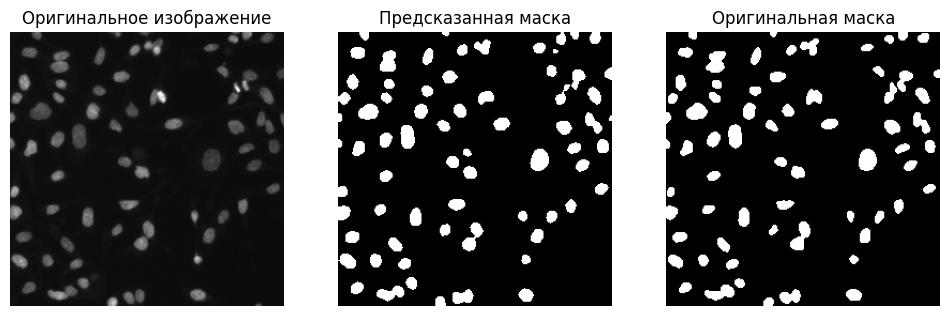

In [79]:
path_predict =os.path.join(TRAIN_DIR,train_df.ImageId.iloc[num_test_img],"images",f"{train_df.ImageId.iloc[num_test_img]}.png") 
predict_and_show_mask(best_deeplab_model, path_predict, test_dlv3_transforms, device="cuda",mode="RGB")

In [80]:
num_test_img = np.random.randint(0,len(train_df))

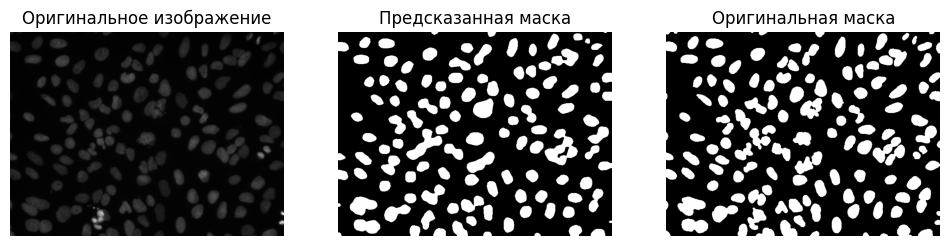

In [81]:
path_predict =os.path.join(TRAIN_DIR,train_df.ImageId.iloc[num_test_img],"images",f"{train_df.ImageId.iloc[num_test_img]}.png") 
predict_and_show_mask(best_deeplab_model, path_predict, test_dlv3_transforms, device="cuda",mode="RGB")

In [66]:
test_test = os.listdir("./data/test")

In [27]:
def predict_and_show_mask1(model, image_path, transform, device="cuda"):
    """
    Загружает изображение, делает предсказание маски и отображает результат.
    
    Args:
        model (torch.nn.Module): Обученная модель.
        image_path (str): Путь к файлу изображения.
        transform (albumentations.Compose): Пайплайн трансформаций.
        device (str): Устройство ('cuda' или 'cpu').
    """
    # 1. Загрузка и предобработка изображения
    image_pil = Image.open(image_path).convert("RGB")
    original_width, original_height = image_pil.size
    

    # Применяем трансформации
    input_tensor = transform(image_pil) 
    
    # Добавляем батчевое измерение и отправляем на устройство
    input_batch = input_tensor.unsqueeze(0).to(device)

    # 2. Предсказание
    model.to(device)
    model.eval() # Переводим модель в режим оценки
    with torch.no_grad():
        prediction = model(input_batch)

    # 3. Постобработка результата
    # Применяем сигмоиду, чтобы получить вероятности
    probs = torch.sigmoid(prediction)
    # Применяем порог 0.5, чтобы получить бинарную маску
    resized_probs = F.interpolate(
        probs, 
        size=(original_height, original_width), # Целевой размер
        mode='bilinear', 
        align_corners=False
    )
    mask = (resized_probs > 0.5).float()
    
    # Переводим маску на CPU, в NumPy и убираем лишние измерения
    mask_np = mask.squeeze().cpu().numpy()

    # Для отображения оригинального изображения, конвертируем PIL в NumPy
    image_np = np.array(image_pil)
    # 4. Визуализация
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))



    
    ax[0].imshow(image_np)
    ax[0].set_title("Оригинальное изображение")
    ax[0].axis('off')
    
    ax[1].imshow(mask_np)
    ax[1].set_title("Предсказанная маска")
    ax[1].axis('off')
    
    
    plt.show()

**Посмотрим как модель сегментирует что-нибудь из тестовой папки(к которой у нас нет готовых масок)**

In [72]:
num_test_img = np.random.randint(0,len(test_test))
num_test_img

4

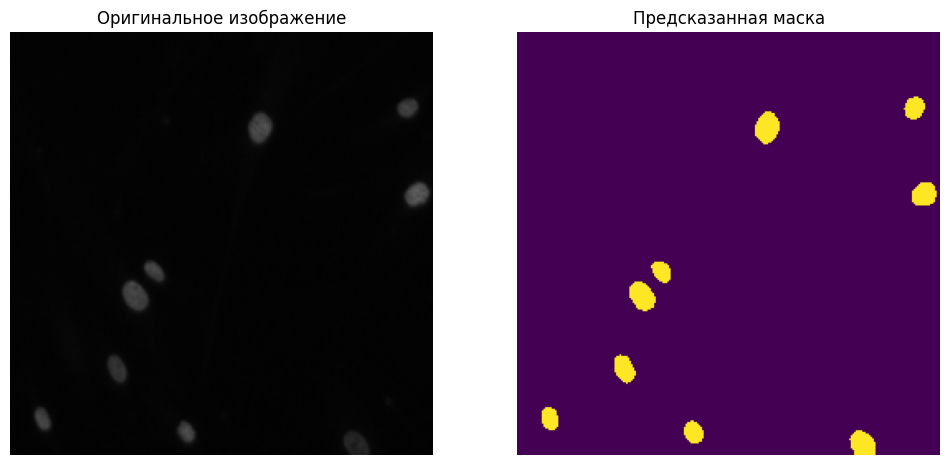

In [73]:
path_predict =os.path.join("./data/test",test_test[num_test_img],"images",f"{test_test[num_test_img]}.png") 
predict_and_show_mask1(best_deeplab_model, path_predict, test_dlv3_transforms, device="cuda")

## Вывод:

**`Сеть на основе DeepLabv3+ показала лучше результат по точности 95%(DeepLab) против 88% у U-net и примерно одинаковый результат по  Dice Score. Обе архитектуры отлично себя показывают в задаче сегментации ядер.`**

*Попробуем улучшить метрики с помощью аугментации. Так же попробуем "подмешать" DICE к loss, возможно это тоже поможет улучшить результат*

# Улучшение Deeplabv3+

In [28]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

## Добавляем аугментацию (одновременно и к маске и к изображению) с помощью albumentations

In [29]:
# Пайплайн для ОБУЧАЮЩЕЙ выборки (с аугментациями)
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=15, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

In [30]:
# Пайплайн для ВАЛИДАЦИОННОЙ выборки (БЕЗ случайных аугментаций)
val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

In [31]:
## Пишем новый класс датасета для применениям аугментации

In [32]:
class DataSetWithAug (data.Dataset):
    def __init__(self,root_dir, image_ids,transform=None):
        """
        Args:
            root_dir (string) : Дириктория до папки train
            image_ids (list)  : Список ID изображений в папке train
            transform (albumentations.Compose): ЕДИНЫЙ пайплайн трансформаций.
        """
        self.root_dir = root_dir
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
            return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_id_path = os.path.join(self.root_dir, img_id)
        
        img_path = os.path.join(img_id_path, "images", f"{img_id}.png")
        # Загружаем изображение и сразу конвертируем в NumPy массив
        image = np.array(Image.open(img_path).convert("RGB"))
        
        mask_folder_path = os.path.join(img_id_path, "masks")
        # Маска тоже будет NumPy массивом
        combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        for mask_file in os.listdir(mask_folder_path):
            mask_path = os.path.join(mask_folder_path, mask_file)
            individual_mask = np.array(Image.open(mask_path).convert("L"))
            combined_mask = np.maximum(combined_mask, individual_mask / 255.0)
        # Применяем трансформации, если они есть
        if self.transform:
            # Передаем и картинку, и маску в пайплайн ОДНОВРЕМЕННО
            transformed = self.transform(image=image, mask=combined_mask)
            image = transformed['image']
            mask = transformed['mask']
        
        # Добавляем канальное измерение для маски
        mask = mask.unsqueeze(0)

        return image, mask

In [33]:
train_set = DataSetWithAug(TRAIN_DIR,train_ids,train_transform)
test_set = DataSetWithAug(TRAIN_DIR,test_ids,val_transform)

In [34]:
train_loader = DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

In [35]:
test_loader = DataLoader(
    test_set,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

In [36]:
dice_loss = smp.losses.DiceLoss(mode='binary') # mode='binary' (1 выходной канал).

In [37]:
bce_loss = nn.BCEWithLogitsLoss()

In [38]:
def combined_loss(predictions, targets, bce_weight=0.55):
    """
    Вычисляет комбинированную функцию потерь.
    
    Args:
        predictions (torch.Tensor): Выход модели (логиты).
        targets (torch.Tensor): Правильные маски.
        bce_weight (float): Вес для BCE Loss (вес для Dice будет 1 - bce_weight).
    """
    # Считаем BCE Loss
    bce = bce_loss(predictions, targets)
    
    # Считаем Dice Loss
    # Важно: DiceLoss из smp ожидает на вход логиты, он сам применит сигмоиду.
    dice = dice_loss(predictions, targets)
    
    # Возвращаем взвешенную сумму
    return bce_weight * bce + (1 - bce_weight) * dice

In [39]:
# Функци
def train_one_epoch_dice_loss(loader, model, optimizer, loss_fn, device):
    """Функция для обучения модели на одной эпохе с подмешиванием
    Dice score к loss функции
    ."""
    loop = tqdm(loader, leave=True)
    model.train() # Переводим модель в режим обучения
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward pass (прямое распространение)
        predictions = model(data)
        loss = combined_loss(predictions, targets)
        # loss = loss_fn(predictions, targets)
        
        # Backward pass (обратное распространение)
        optimizer.zero_grad() # Обнуляем градиенты
        loss.backward()       # Считаем градиенты
        optimizer.step()      # Обновляем веса
        
        # Обновляем информацию в progress bar
        loop.set_postfix(loss=loss.item())

In [40]:
deeplab_model = DeepLabV3Plus(
        # in_channels=1, 
        num_classes=1, # Бинарная сегментация (ядро/не ядро)
        pretrained=True # Используем предобученный ResNet50
    ).to(DEVICE)

In [41]:

optim = torch.optim.Adam(deeplab_model.parameters(),lr=1e-4)

In [42]:
best_val_dice = -1.0
scheduler = StepLR(optim, step_size=4, gamma=0.75) # Планировщик для LR

In [47]:
NUM_EPOCHS = 24 # 
for epoch in range(NUM_EPOCHS):
    print(f"--- Эпоха {epoch+1}/{NUM_EPOCHS} ---")
    
    # Запускаем обучение на одной эпохе
    train_one_epoch(train_loader, deeplab_model, optim, bce_loss, DEVICE)
    
    # Проверяем качество на валидационной выборке
    current_dice = check_accuracy(test_loader, deeplab_model, DEVICE)
    scheduler.step()
    # Сохраняем модель, если она показала лучший результат
    if current_dice > best_val_dice:
        best_val_dice = current_dice
        torch.save(deeplab_model.state_dict(), "best_deeplabv3withaug.pth")
        print("=> Модель сохранена как лучшая")

print("--- Обучение завершено ---")


--- Эпоха 1/24 ---


100%|███████████████████████████████| 67/67 [01:44<00:00,  1.56s/it, loss=0.172]


Validation Accuracy: 95.69%
Validation Dice Score: 0.8574
=> Модель сохранена как лучшая
--- Эпоха 2/24 ---


100%|███████████████████████████████| 67/67 [01:50<00:00,  1.65s/it, loss=0.144]


Validation Accuracy: 96.19%
Validation Dice Score: 0.8680
=> Модель сохранена как лучшая
--- Эпоха 3/24 ---


100%|███████████████████████████████| 67/67 [01:50<00:00,  1.65s/it, loss=0.118]


Validation Accuracy: 96.28%
Validation Dice Score: 0.8742
=> Модель сохранена как лучшая
--- Эпоха 4/24 ---


100%|████████████████████████████████| 67/67 [01:50<00:00,  1.64s/it, loss=0.13]


Validation Accuracy: 96.65%
Validation Dice Score: 0.8789
=> Модель сохранена как лучшая
--- Эпоха 5/24 ---


100%|███████████████████████████████| 67/67 [01:50<00:00,  1.64s/it, loss=0.203]


Validation Accuracy: 96.81%
Validation Dice Score: 0.8892
=> Модель сохранена как лучшая
--- Эпоха 6/24 ---


100%|███████████████████████████████| 67/67 [01:49<00:00,  1.63s/it, loss=0.213]


Validation Accuracy: 96.74%
Validation Dice Score: 0.8858
--- Эпоха 7/24 ---


100%|███████████████████████████████| 67/67 [01:49<00:00,  1.63s/it, loss=0.112]


Validation Accuracy: 96.96%
Validation Dice Score: 0.8894
=> Модель сохранена как лучшая
--- Эпоха 8/24 ---


100%|██████████████████████████████| 67/67 [01:50<00:00,  1.64s/it, loss=0.0978]


Validation Accuracy: 96.92%
Validation Dice Score: 0.8868
--- Эпоха 9/24 ---


100%|███████████████████████████████| 67/67 [01:53<00:00,  1.69s/it, loss=0.136]


Validation Accuracy: 97.07%
Validation Dice Score: 0.8969
=> Модель сохранена как лучшая
--- Эпоха 10/24 ---


100%|███████████████████████████████| 67/67 [01:58<00:00,  1.77s/it, loss=0.115]


Validation Accuracy: 97.06%
Validation Dice Score: 0.8971
=> Модель сохранена как лучшая
--- Эпоха 11/24 ---


100%|███████████████████████████████| 67/67 [02:01<00:00,  1.81s/it, loss=0.116]


Validation Accuracy: 97.10%
Validation Dice Score: 0.8974
=> Модель сохранена как лучшая
--- Эпоха 12/24 ---


100%|██████████████████████████████| 67/67 [02:08<00:00,  1.91s/it, loss=0.0682]


Validation Accuracy: 97.04%
Validation Dice Score: 0.8949
--- Эпоха 13/24 ---


100%|██████████████████████████████| 67/67 [02:11<00:00,  1.96s/it, loss=0.0763]


Validation Accuracy: 97.07%
Validation Dice Score: 0.8963
--- Эпоха 14/24 ---


100%|████████████████████████████████| 67/67 [02:03<00:00,  1.85s/it, loss=0.11]


Validation Accuracy: 97.16%
Validation Dice Score: 0.8986
=> Модель сохранена как лучшая
--- Эпоха 15/24 ---


100%|██████████████████████████████| 67/67 [02:03<00:00,  1.84s/it, loss=0.0741]


Validation Accuracy: 97.16%
Validation Dice Score: 0.8985
--- Эпоха 16/24 ---


100%|███████████████████████████████| 67/67 [02:01<00:00,  1.82s/it, loss=0.111]


Validation Accuracy: 97.24%
Validation Dice Score: 0.8996
=> Модель сохранена как лучшая
--- Эпоха 17/24 ---


100%|███████████████████████████████| 67/67 [02:00<00:00,  1.80s/it, loss=0.126]


Validation Accuracy: 97.17%
Validation Dice Score: 0.8973
--- Эпоха 18/24 ---


100%|█████████████████████████████████| 67/67 [02:01<00:00,  1.81s/it, loss=0.1]


Validation Accuracy: 97.14%
Validation Dice Score: 0.8996
=> Модель сохранена как лучшая
--- Эпоха 19/24 ---


100%|██████████████████████████████| 67/67 [02:04<00:00,  1.86s/it, loss=0.0742]


Validation Accuracy: 97.15%
Validation Dice Score: 0.8994
--- Эпоха 20/24 ---


100%|██████████████████████████████| 67/67 [01:58<00:00,  1.77s/it, loss=0.0805]


Validation Accuracy: 97.26%
Validation Dice Score: 0.9027
=> Модель сохранена как лучшая
--- Эпоха 21/24 ---


100%|██████████████████████████████| 67/67 [01:59<00:00,  1.78s/it, loss=0.0827]


Validation Accuracy: 97.23%
Validation Dice Score: 0.9003
--- Эпоха 22/24 ---


100%|███████████████████████████████| 67/67 [01:59<00:00,  1.78s/it, loss=0.107]


Validation Accuracy: 97.32%
Validation Dice Score: 0.9033
=> Модель сохранена как лучшая
--- Эпоха 23/24 ---


100%|███████████████████████████████| 67/67 [02:00<00:00,  1.79s/it, loss=0.114]


Validation Accuracy: 97.28%
Validation Dice Score: 0.9001
--- Эпоха 24/24 ---


100%|███████████████████████████████| 67/67 [02:01<00:00,  1.82s/it, loss=0.104]


Validation Accuracy: 97.10%
Validation Dice Score: 0.8999
--- Обучение завершено ---


**`С помощью аугментации и "подмешивания" Dice в loss функцию удалось поднять метрики на 2%`**

In [48]:
best_deeplab_model_aug = DeepLabV3Plus(
        # in_channels=1, 
        num_classes=1, # Бинарная сегментация (ядро/не ядро)
        pretrained=False 
    ).to(DEVICE)

In [50]:
best_deeplab_model_aug.load_state_dict(torch.load("best_deeplabv3withaug.pth",map_location=torch.device(device)))

<All keys matched successfully>

In [51]:
best_deeplab_model_aug.eval()

DeepLabV3Plus(
  (backbone_low): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [52]:
num_test_img = np.random.randint(0,len(train_df))

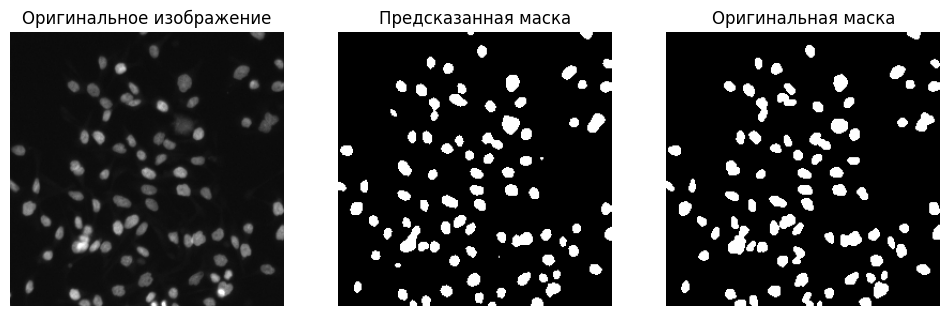

In [55]:
path_predict =os.path.join(TRAIN_DIR,train_df.ImageId.iloc[num_test_img],"images",f"{train_df.ImageId.iloc[num_test_img]}.png") 
predict_and_show_mask(best_deeplab_model_aug, path_predict, test_dlv3_transforms, device="cuda",mode="RGB")

In [56]:
num_test_img = np.random.randint(0,len(train_df))

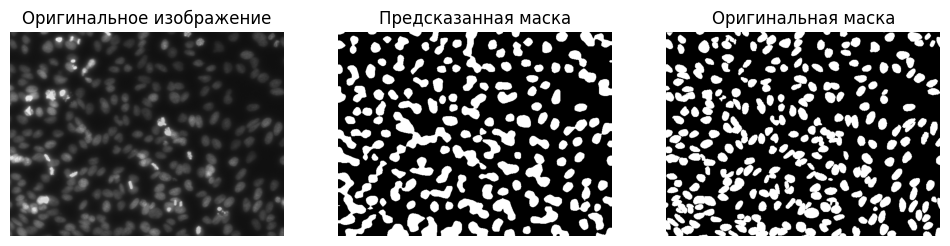

In [57]:
path_predict =os.path.join(TRAIN_DIR,train_df.ImageId.iloc[num_test_img],"images",f"{train_df.ImageId.iloc[num_test_img]}.png") 
predict_and_show_mask(best_deeplab_model_aug, path_predict, test_dlv3_transforms, device="cuda",mode="RGB")

In [58]:
num_test_img = np.random.randint(0,len(train_df))

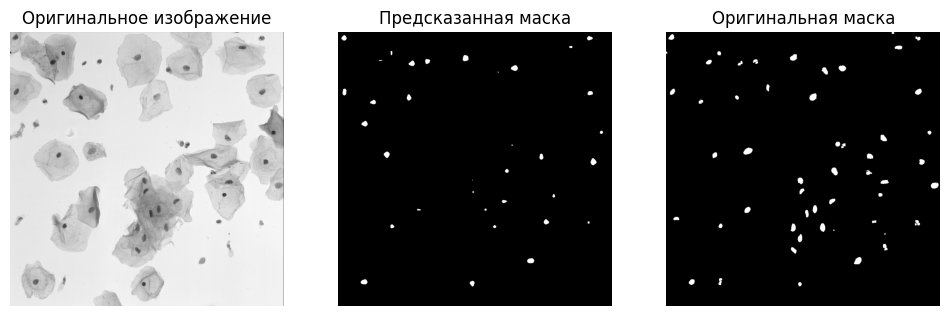

In [59]:
path_predict =os.path.join(TRAIN_DIR,train_df.ImageId.iloc[num_test_img],"images",f"{train_df.ImageId.iloc[num_test_img]}.png") 
predict_and_show_mask(best_deeplab_model_aug, path_predict, test_dlv3_transforms, device="cuda",mode="RGB")

In [61]:
test_test = os.listdir("./data/test")

In [62]:
num_test_img = np.random.randint(0,len(test_test))

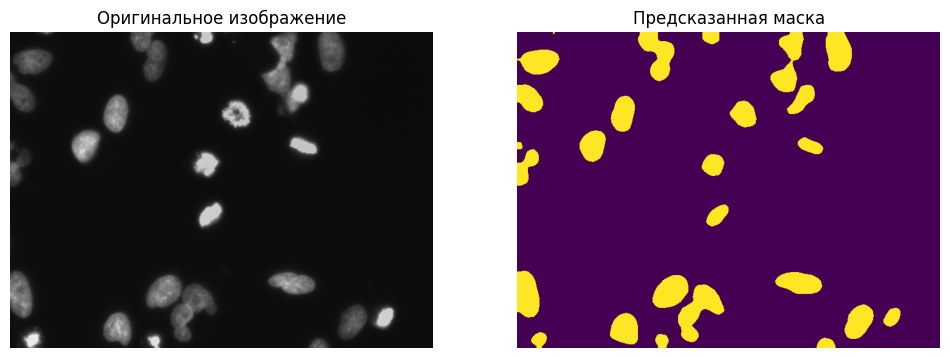

In [63]:
path_predict =os.path.join("./data/test",test_test[num_test_img],"images",f"{test_test[num_test_img]}.png") 
predict_and_show_mask1(best_deeplab_model_aug, path_predict, test_dlv3_transforms, device="cuda")

In [66]:
num_test_img = np.random.randint(0,len(test_test))

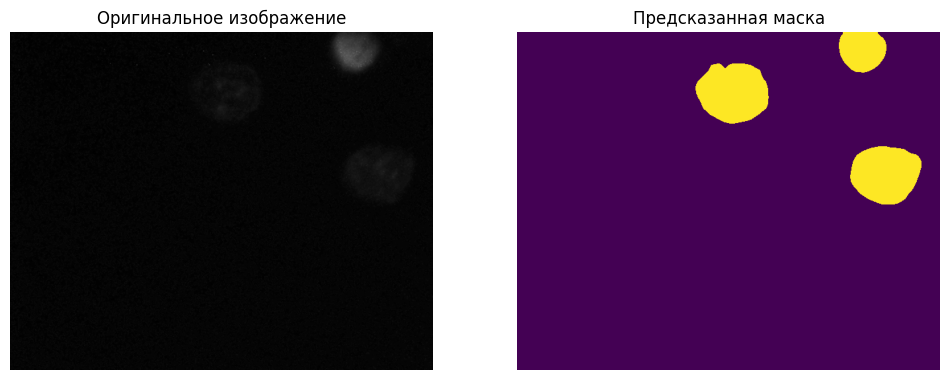

In [67]:
path_predict =os.path.join("./data/test",test_test[num_test_img],"images",f"{test_test[num_test_img]}.png") 
predict_and_show_mask1(best_deeplab_model_aug, path_predict, test_dlv3_transforms, device="cuda")

In [70]:
num_test_img = np.random.randint(0,len(test_test))

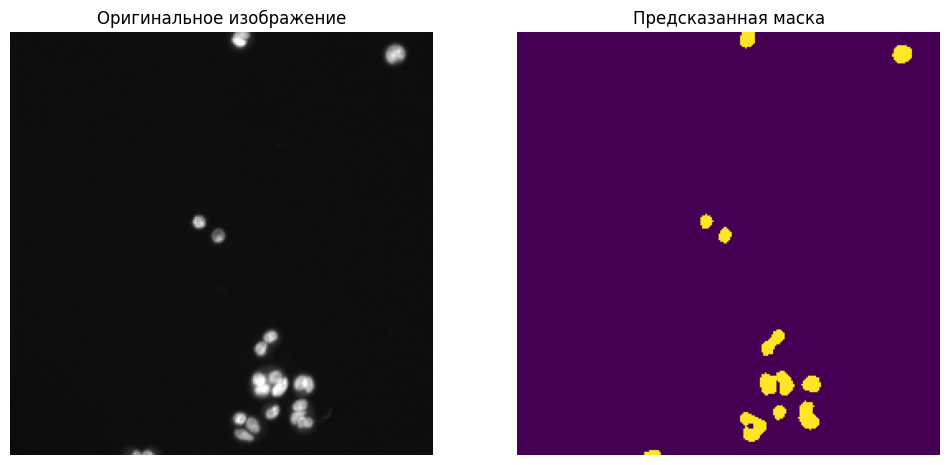

In [71]:
path_predict =os.path.join("./data/test",test_test[num_test_img],"images",f"{test_test[num_test_img]}.png") 
predict_and_show_mask1(best_deeplab_model_aug, path_predict, test_dlv3_transforms, device="cuda")